# **Human Activity Recognition Using Smartphone Sensor Data**

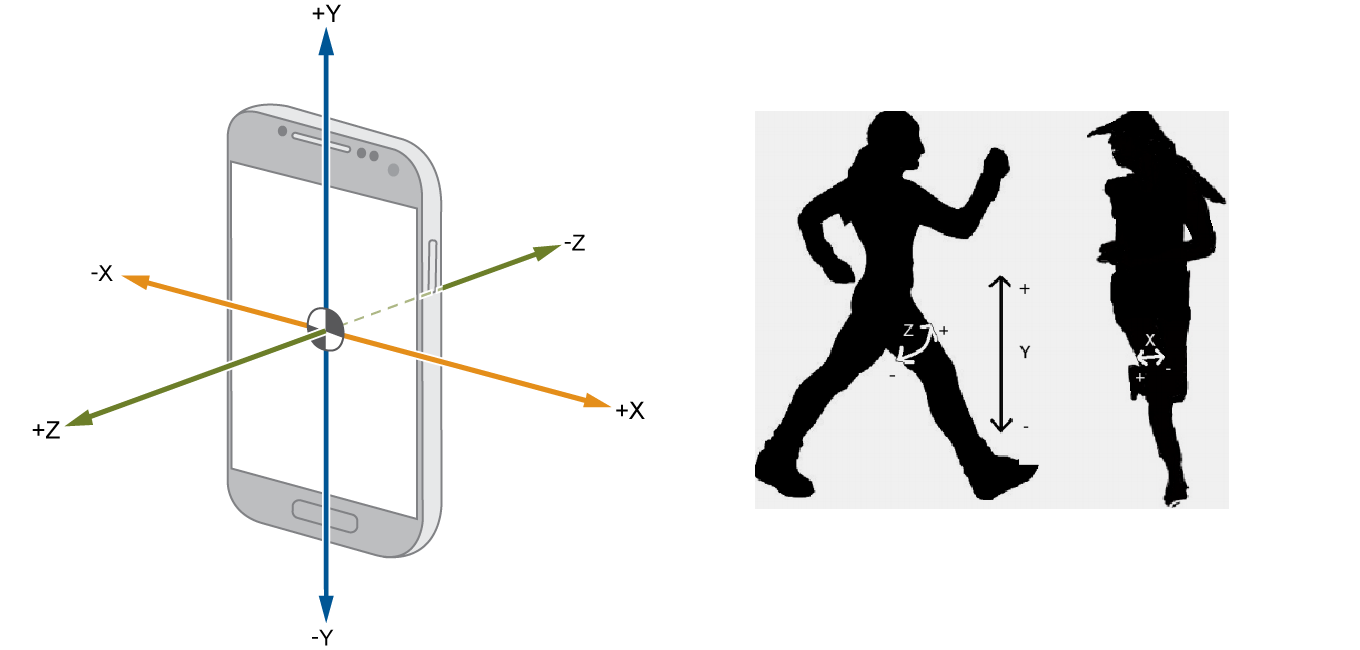

## **Environment Setup -** Importing The Required Libraries and Packages

In [2]:
%tensorflow_version 1.x

In [3]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn import metrics
from sklearn.model_selection import train_test_split
import os
from IPython.display import clear_output


%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

In [4]:
print(tf.__version__)  # We are using Tensorflow verstion 1.15

1.15.2


# About The Dataset
The project uses [wireless sensor data mining (WISDM) dataset](https://www.cis.fordham.edu/wisdm/dataset.php), the data has been collected through controlled laboratory experiments. The dataset contains over a million observations for 36 users for six activities combined. The six activities are - walking, jogging, walking upstairs, walking downstairs, sitting, and standing.

In the experiments used for collecting the accelerometer data, a single device - a modern smartphone, is used rather than multiple accelerometer devices placed at several positions on the user's body. No further equipment or actions are needed by the user.

The dataset contains six columns- the first three columns are for user-id, activity label, and timestamp; the last three columns are for accelerometer readings for x,y, and z directions respectively. The accelerometer data has been collected at a frequency of 20hz, therefore we have 20 observations per second.

### **Loading The Dataset**

In [5]:
columns = ['user','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']
df = pd.read_csv('data/WISDM_ar_v1.1_raw.txt', header = None, names = columns)
df = df.dropna()    # Dropping observations with NA values
df.head()

user activity       timestamp    x-axis     y-axis    z-axis
0    33  Jogging  49105962326000 -0.694638  12.680544  0.503953
1    33  Jogging  49106062271000  5.012288  11.264028  0.953424
2    33  Jogging  49106112167000  4.903325  10.882658 -0.081722
3    33  Jogging  49106222305000 -0.612916  18.496431  3.023717
4    33  Jogging  49106332290000 -1.184970  12.108489  7.205164

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1098203 entries, 0 to 1098203
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user       1098203 non-null  int64  
 1   activity   1098203 non-null  object 
 2   timestamp  1098203 non-null  int64  
 3   x-axis     1098203 non-null  float64
 4   y-axis     1098203 non-null  float64
 5   z-axis     1098203 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 58.7+ MB


# Distribution of Activities in the Dataset

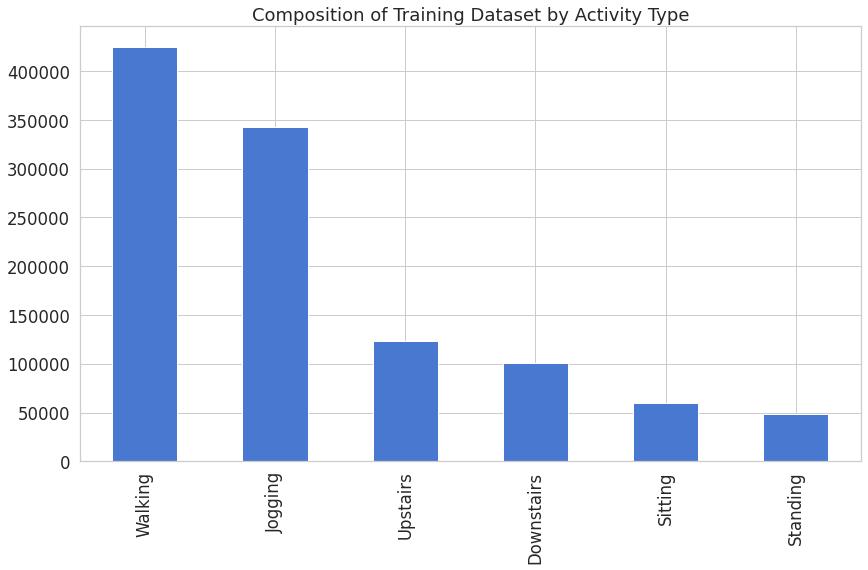

In [7]:
df['activity'].value_counts().plot(kind='bar', title='Composition of Training Dataset by Activity Type');

The readings for the activities of walking and jogging are much more(450k, 340k) as compared to the other activities(<125k).

## Distribution of Activities Conducted Per User

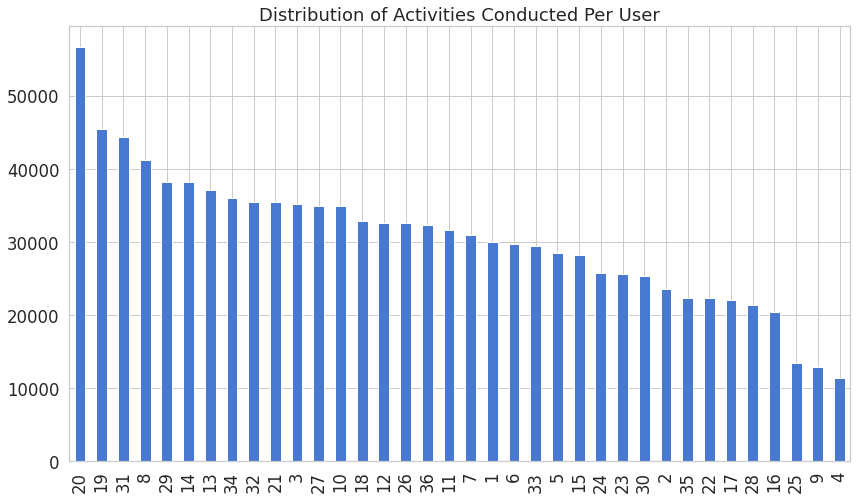

In [8]:
df['user'].value_counts().plot(kind='bar', title='Distribution of Activities Conducted Per User');


## Plotting The Accelerometer Data For Different Activities

In [9]:
# Defining the plotting function
def plot_activity(activity, df):
    data = df[df['activity'] == activity][['x-axis', 'y-axis', 'z-axis']][:200]  # 200 Readings ~ 10 Seconds
    axis = data.plot(subplots=True, figsize=(8, 7), 
                     title=activity)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))

### Activity - Sitting

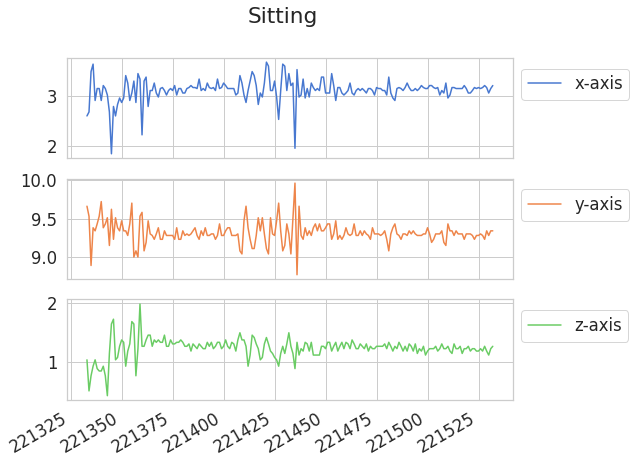

In [10]:
plot_activity("Sitting", df)

### Activity - Standing

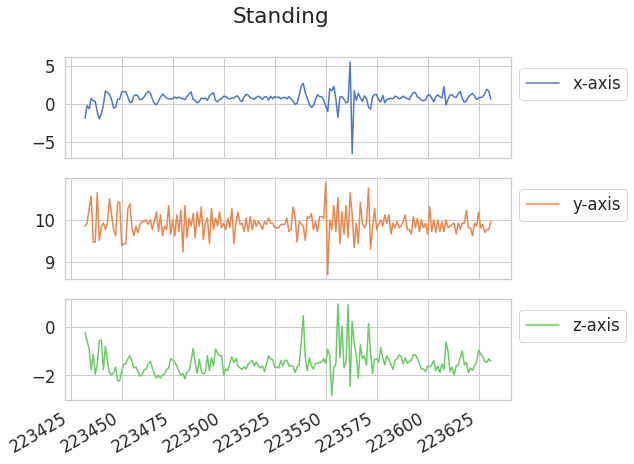

In [11]:
plot_activity("Standing", df)

### Activity - Walking

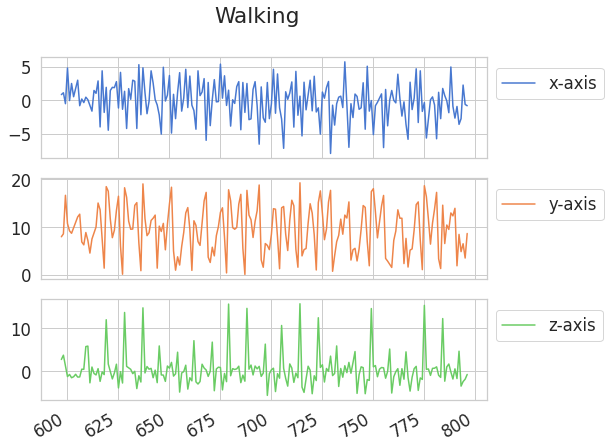

In [12]:
plot_activity("Walking", df)

### Activity - Jogging

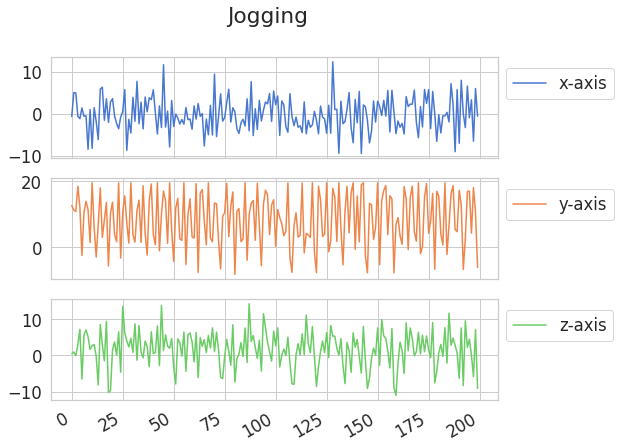

In [13]:
plot_activity("Jogging", df)

## Data Preprocessing
Accelerometer readings are being recorded at a frequency of 20hz, i.e. we have 20 reading for every second. The raw data is available in the form of a time series, we shall generate observations by transforming the data into 10 second segments. The number of readings taken in a time interval of 10 seconds is 200.

The 10 seconds interval provides sufficient time to record multiple repetitions of the motion involved in the six activities. The number of features is 3 which comprises of the accelerometer readings in the x,y, and z directions.

In [14]:
N_TIME_STEPS = 200  # Number of readings in each 10 second interval
N_FEATURES = 3  # Number of features - accelerometer readings in x,y, and z directions
step = 20
segments = []
labels = []
for i in range(0, len(df) - N_TIME_STEPS, step):
    xs = df['x-axis'].values[i: i + N_TIME_STEPS]
    ys = df['y-axis'].values[i: i + N_TIME_STEPS]
    zs = df['z-axis'].values[i: i + N_TIME_STEPS]
    label = stats.mode(df['activity'][i: i + N_TIME_STEPS])[0][0]
    segments.append([xs, ys, zs])
    labels.append(label)

In [15]:
np.array(segments).shape

(54901, 3, 200)

In [16]:
# Reshaping the tensor
reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)

Our final reshaped tensor contains 54,901 obnservations, each observation contains 200 sets of accelerometer readings for the 3 directions x,y, and z. Hence, the shape - (54901,200,3).

In [17]:
reshaped_segments.shape

(54901, 200, 3)

In [18]:

labels[0]

array([0., 1., 0., 0., 0., 0.], dtype=float32)

Splitting the dataset into training and testing sets in 80:20 ratio respectively.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
        reshaped_segments, labels, test_size=0.2, random_state=RANDOM_SEED)

In [20]:
print(len(X_train), len(X_test))

43920 10981


## Building The Model
Classical machine learning approaches like Support Vector Machines and Random Forests require extensive amounts of feature creation. In the [UCI HAR research](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones) on human activity recognition using smartphone sensor data, feature creation is one of the largest and most important tasks, over 550 features are created for the classical models to be able to predict the activity being performed with acceptable accuracy. 

Recurrent Neural Networks (RNN), especially Long Short Term Memory (LSTM) neural networks which are a special kind of RNN are able to predict the activities accurately with little to no feature engineering.

In [21]:
N_CLASSES = 6  # The number of activities to differentiate between
N_HIDDEN_UNITS = 64

In [22]:
def create_LSTM_model(inputs):
    W = {
        'hidden': tf.Variable(tf.random_normal([N_FEATURES, N_HIDDEN_UNITS])),
        'output': tf.Variable(tf.random_normal([N_HIDDEN_UNITS, N_CLASSES]))
    }
    biases = {
        'hidden': tf.Variable(tf.random_normal([N_HIDDEN_UNITS], mean=1.0)),
        'output': tf.Variable(tf.random_normal([N_CLASSES]))
    }
    
    X = tf.transpose(inputs, [1, 0, 2])
    X = tf.reshape(X, [-1, N_FEATURES])
    hidden = tf.nn.relu(tf.matmul(X, W['hidden']) + biases['hidden'])
    hidden = tf.split(hidden, N_TIME_STEPS, 0)

    # Stack 2 LSTM layers
    lstm_layers = [tf.contrib.rnn.BasicLSTMCell(N_HIDDEN_UNITS, forget_bias=1.0) for _ in range(2)]
    lstm_layers = tf.contrib.rnn.MultiRNNCell(lstm_layers)

    outputs, _ = tf.contrib.rnn.static_rnn(lstm_layers, hidden, dtype=tf.float32)

    # Get output for the last time step
    lstm_last_output = outputs[-1]

    return tf.matmul(lstm_last_output, W['output']) + biases['output']

In [23]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, N_TIME_STEPS, N_FEATURES], name="input")
Y = tf.placeholder(tf.float32, [None, N_CLASSES])

In [24]:
pred_Y = create_LSTM_model(X)
pred_softmax = tf.nn.softmax(pred_Y, name="y_")
clear_output()

In [25]:
L2_LOSS = 0.0015

l2 = L2_LOSS * \
    sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = pred_Y, labels = Y)) + l2

clear_output()

### Defining Optimizer and Accuracy
For our LSTM model we are using the Adam optimization algorithm which is an extension of the stochastic gradient descent. Tensorflow provides us with the AdamOptimizer function which takes in the learning rate, beta1(exponential decay rate for the 1st moment estimates), beta2(exponential decay rate for the 2nd moment estimates.) and epsilon(a small constant for numerical stability.) as its parameters. We have set the learning rate to 0.0025 and are using the default values for the other parameters.

In [26]:
LEARNING_RATE = 0.0025

optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss)

correct_pred = tf.equal(tf.argmax(pred_softmax, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, dtype=tf.float32))

## Training
We have set the number of epochs to 50, and the batch size to 1024.

In [27]:
N_EPOCHS = 50
BATCH_SIZE = 1024

In [28]:
saver = tf.train.Saver()

history = dict(train_loss=[], 
                     train_acc=[], 
                     test_loss=[], 
                     test_acc=[])

sess=tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

train_count = len(X_train)

for i in range(1, N_EPOCHS + 1):
    for start, end in zip(range(0, train_count, BATCH_SIZE),
                          range(BATCH_SIZE, train_count + 1,BATCH_SIZE)):
        sess.run(optimizer, feed_dict={X: X_train[start:end],
                                       Y: y_train[start:end]})

    _, acc_train, loss_train = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_train, Y: y_train})

    _, acc_test, loss_test = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_test, Y: y_test})

    history['train_loss'].append(loss_train)
    history['train_acc'].append(acc_train)
    history['test_loss'].append(loss_test)
    history['test_acc'].append(acc_test)

    if i != 1 and i % 10 != 0:
        continue

    print(f'epoch: {i} test accuracy: {acc_test} loss: {loss_test}')
    
predictions, acc_final, loss_final = sess.run([pred_softmax, accuracy, loss], feed_dict={X: X_test, Y: y_test})

print()
print(f'final results: accuracy: {acc_final} loss: {loss_final}')

epoch: 1 test accuracy: 0.8086695075035095 loss: 1.2737581729888916
epoch: 10 test accuracy: 0.913942277431488 loss: 0.6572438478469849
epoch: 20 test accuracy: 0.9626627564430237 loss: 0.40823566913604736
epoch: 30 test accuracy: 0.9746835231781006 loss: 0.3102339506149292
epoch: 40 test accuracy: 0.9729532599449158 loss: 0.2775347828865051
epoch: 50 test accuracy: 0.9728622436523438 loss: 0.252360075712204

final results: accuracy: 0.9728622436523438 loss: 0.252360075712204


### Saving The Model to Disk

**We have finished training the model, let us save the model/tensor-graph to the disk**

In [30]:
pickle.dump(predictions, open("predictions.p", "wb"))
pickle.dump(history, open("history.p", "wb"))
tf.train.write_graph(sess.graph_def, '.', './checkpoint/har.pbtxt')  
saver.save(sess, save_path = "./checkpoint/har.ckpt")
sess.close()

### Loading the saved model from disk

In [31]:
history = pickle.load(open("history.p", "rb"))
predictions = pickle.load(open("predictions.p", "rb"))

## Model Evaluation
Let us take a look at the accuracy and loss as the model trains for more number of eopchs. Finally we shall also create a confusion matrix using sklearn's metrics package.

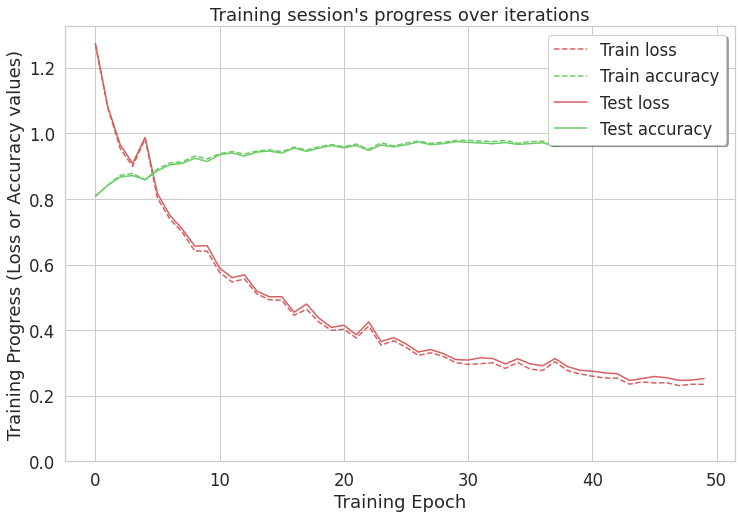

In [32]:
plt.figure(figsize=(12, 8))

plt.plot(np.array(history['train_loss']), "r--", label="Train loss")
plt.plot(np.array(history['train_acc']), "g--", label="Train accuracy")

plt.plot(np.array(history['test_loss']), "r-", label="Test loss")
plt.plot(np.array(history['test_acc']), "g-", label="Test accuracy")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training Epoch')
plt.ylim(0)

plt.show()

The test accuracy has gone up to 97% and the loss has gone down to 0.25.

### Creating The Confusion Matrix

In [33]:
# Creating labels for the confusion matrix
LABELS = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']

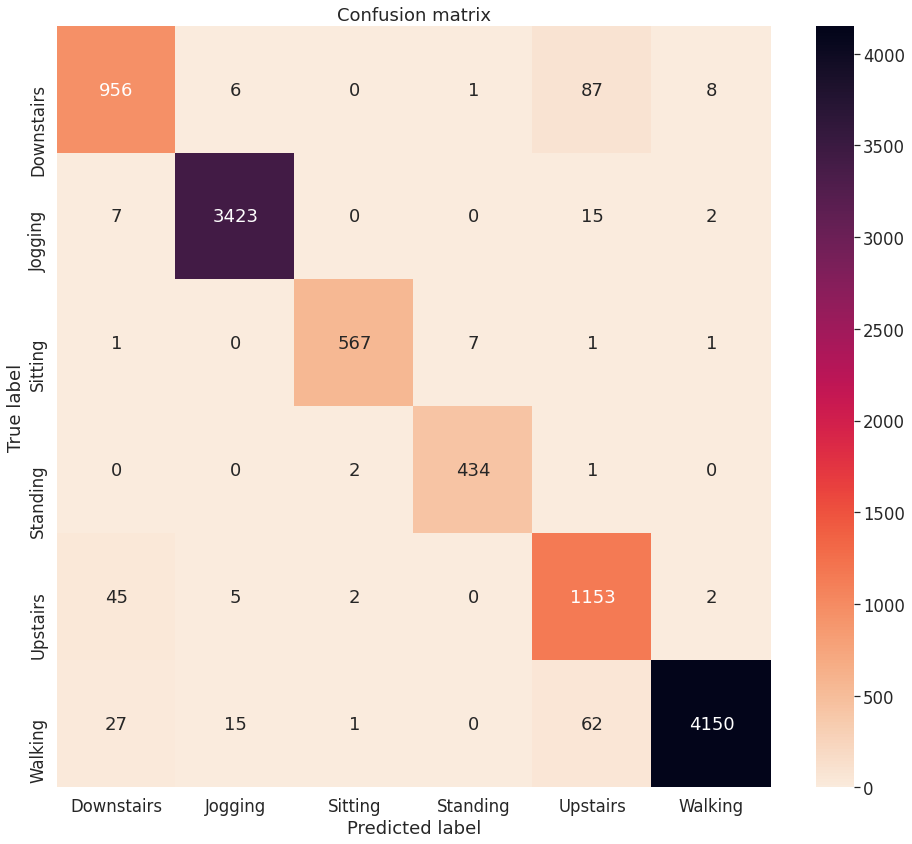

In [34]:
max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)
confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d",cmap=sns.cm.rocket_r);
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show();

In [39]:
metrics.accuracy_score(max_test,max_predictions)

0.9728622165558692

## We have achieved an accuracy of 97.28% on the test data.

# Exporting The Model
**Exporting the model/tensorflow-graph to be used in the android application**

In [35]:
from tensorflow.python.tools import freeze_graph

MODEL_NAME = 'har'

input_graph_path = 'checkpoint/' + MODEL_NAME+'.pbtxt'
checkpoint_path = './checkpoint/' +MODEL_NAME+'.ckpt'
restore_op_name = "save/restore_all"
filename_tensor_name = "save/Const:0"
output_frozen_graph_name = 'frozen_'+MODEL_NAME+'.pb'

freeze_graph.freeze_graph(input_graph_path, input_saver="",
                          input_binary=False, input_checkpoint=checkpoint_path, 
                          output_node_names="y_", restore_op_name="save/restore_all",
                          filename_tensor_name="save/Const:0", 
                          output_graph=output_frozen_graph_name, clear_devices=True, initializer_nodes="")

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./checkpoint/har.ckpt
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 8 variables.
INFO:tensorflow:Converted 8 variables to const ops.


node {
  name: "input"
  op: "Placeholder"
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "shape"
    value {
      shape {
        dim {
          size: -1
        }
        dim {
          size: 200
        }
        dim {
          size: 3
        }
      }
    }
  }
}
node {
  name: "Variable"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_FLOAT
        tensor_shape {
          dim {
            size: 3
          }
          dim {
            size: 64
          }
        }
        tensor_content: "\362\3405\277\032\324l\274\367\252\216=\014\376\327\276m\335\216\276$\020\332\276xg\351\275V\243\204?\257()\277\333\215\036\276\216\264\007>\262\027&\276\0325\304>S\221\351?`\202,\277\336.\277\276\373xs?\376*\306=\221\002\334?\235\254\277\276^\005\231\276G4\252=\251\223\206?\032\243n>\022/\032>.$\251=#\224\014\277\210z\375>\222|\301\275\203\246

In [ ]:
!zip -r /content/file.zip /content

In [37]:
from google.colab import files
files.download("/content/file.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>